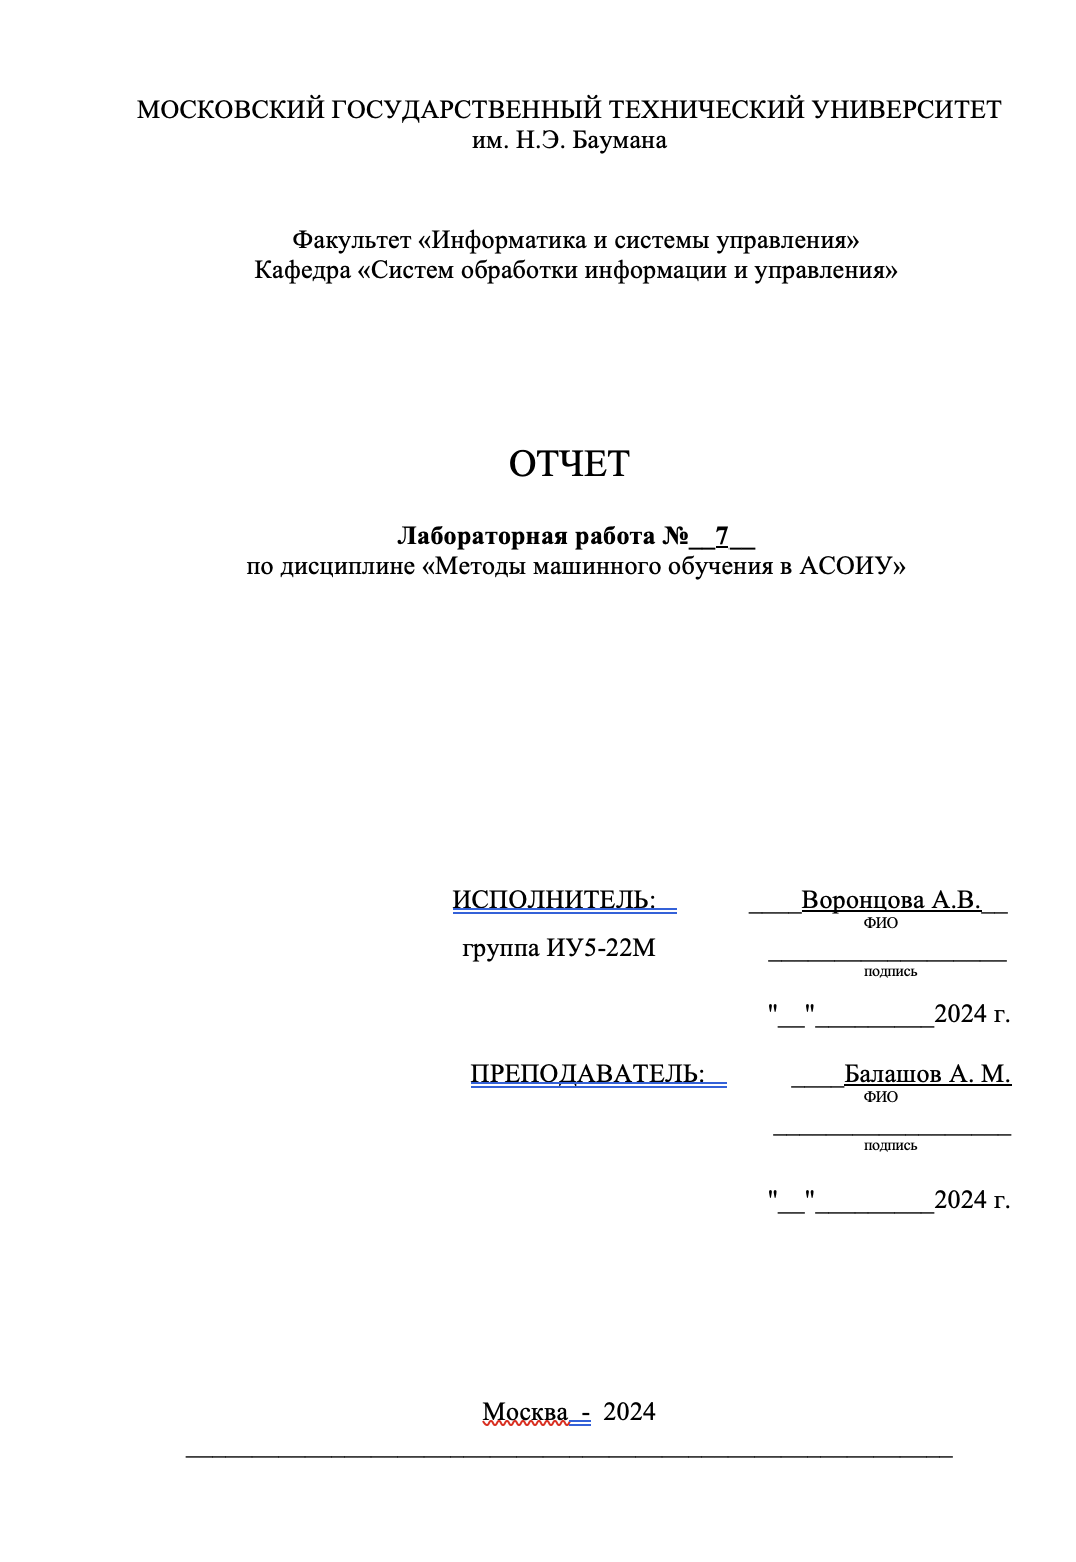

### **Задание:**
Реализуйте любой алгоритм семейства Actor-Critic для произвольной среды.

In [1]:
pip install gym torch numpy matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt


###  Определение модели Actor-Critic

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, state_space, action_space):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.actor = nn.Linear(128, action_space)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        action_probs = torch.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_probs, state_values


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Обучение модели

In [4]:
def train(env, policy, optimizer, episodes):
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0

        while True:
            state = torch.FloatTensor(state).unsqueeze(0)
            probs, value = policy(state)
            m = Categorical(probs)
            action = m.sample()
            next_state, reward, done, _ = env.step(action.item())

            log_prob = m.log_prob(action)
            entropy += m.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float32))
            masks.append(torch.tensor([1-done], dtype=torch.float32))

            state = next_state

            if done:
                break

        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        _, next_value = policy(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        episode_rewards.append(total_reward)

    return episode_rewards

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


###  Запуск обучения

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


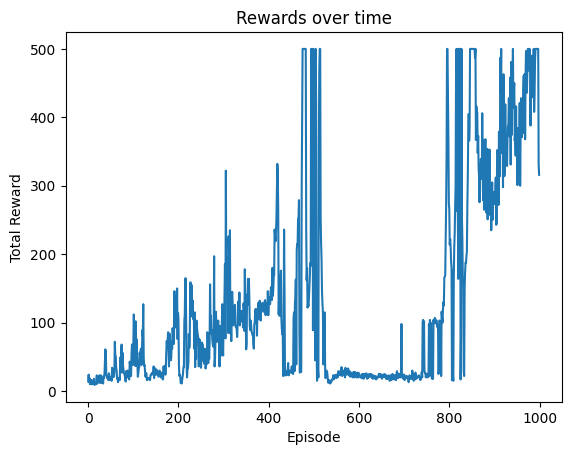

In [5]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

episodes = 1000
rewards = train(env, policy, optimizer, episodes)

plt.plot(rewards)
plt.title('Rewards over time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
